In [1]:
# coding=u8
import vectorbt as vbt
import pandas_ta as ta
import pandas as pd
import warnings
import numpy as np
import datetime

warnings.simplefilter(action='ignore')

In [2]:
data = vbt.YFData.download("BTC-USD", 
                    start="2021-01-01",
                    end="2022-01-01").get()
data.reset_index(inplace=True)
data = data.rename(columns={'Date':'d','Open':'o','High':'h','Low':'l','Close':'c','Volume':'v'})
data = data[['d','o','h','l','c','v']]
data.head()

,d,o,h,l,c,v
0,2020-12-31 00:00:00+00:00,28841.574219,29244.876953,28201.992188,29001.720703,46754964848
1,2021-01-01 00:00:00+00:00,28994.009766,29600.626953,28803.585938,29374.152344,40730301359
2,2021-01-02 00:00:00+00:00,29376.455078,33155.117188,29091.181641,32127.267578,67865420765
3,2021-01-03 00:00:00+00:00,32129.408203,34608.558594,32052.316406,32782.023438,78665235202
4,2021-01-04 00:00:00+00:00,32810.949219,33440.218750,28722.755859,31971.914062,81163475344


In [3]:
def build_df(df, bb_len, rsi_len, rsi_v, buy_signal_cnt_limit):
    entry_list = {}
    exit_list = {}
    
    last_buy_signal_cnt = 0
    in_position = False
    
    df_copy = df.copy()
    df_copy[['lower','mid','upper','bandwidth','percent']] =\
                ta.bbands(df_copy['c'], length=bb_len, std=2.5)
    df_copy = df_copy.dropna(subset=['lower'])
    df_copy['rsi'] = ta.rsi(df_copy['c'], length=rsi_len)
    df_copy['cross_rsi'] = ta.above_value(df_copy['rsi'], rsi_v)
    df_copy['ma'] = ta.sma(df_copy['c'], length=200)
    
    for i, (index, row) in enumerate(df_copy.iterrows()):
        entry_list[index] = False
        exit_list[index] = False
        if (row['c'] < row['lower']) and (row['c'] > row['ma']):
            # 入场条件1
            limit_price = df_copy.loc[df_copy.index[i-1], 'c'] * 0.97
            if row['l'] < limit_price:
                # 入场条件2
                entry_list[index] = True
                in_position = True
                df_copy.at[index, 'price'] = limit_price
                last_buy_signal_cnt = 0
            
        if in_position:
            last_buy_signal_cnt += 0

        if row['cross_rsi'] == 1:
            exit_list[index] = True
            df_copy.at[index,'price'] = row['c']
            last_buy_signal_cnt = 0

        if last_buy_signal_cnt > buy_signal_cnt_limit:
            last_buy_signal_cnt = 0
        
    df_copy['entry'] = entry_list.values()
    df_copy['exit'] = exit_list.values()
    
    return df_copy


In [4]:
# df_ = build_df(20, 2, 50, 10)
param_list = []

for x in range(15, 30):
    for y in range(2,5):
        df_ = build_df(data, x, y, 50, 10)
        pf = vbt.Portfolio.from_signals(df_['c'], entries=df_['entry'], exits=df_['exit'], price=df_['price'],
                                    init_cash=30000, accumulate=True)
        winrate = pf.stats()[r'Win Rate [%]']
        total_return = pf.stats()[r'Total Return [%]']
        total_profit = pf.total_profit()
        max_drawdown = pf.max_drawdown()
        total_trades = len(pf.trades)
        # print('total profit', total_profit)
        print('total_return', total_return)
        # print('total trades', total_trades)
        param_list.append((x,y,total_return,total_trades,winrate))


total_return -2.48164139354342
total_return -5.054386998327961
total_return -3.6390688654371477
total_return -2.48164139354342
total_return -5.054386998327961
total_return -3.6390688654371477
total_return -2.48164139354342
total_return -5.054386998327961
total_return -3.6390688654371477
total_return -2.48164139354342
total_return -5.054386998327961
total_return -3.6390688654371477
total_return -2.48164139354342
total_return -5.054386998327961
total_return -3.6390688654371477
total_return -2.48164139354342
total_return -5.054386998327961
total_return -3.6390688654371477
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0
total_return 0.0

In [5]:
param_list

[(15, 2, -2.48164139354342, 1, 0.0),
 (15, 3, -5.054386998327961, 1, 0.0),
 (15, 4, -3.6390688654371477, 1, 0.0),
 (16, 2, -2.48164139354342, 1, 0.0),
 (16, 3, -5.054386998327961, 1, 0.0),
 (16, 4, -3.6390688654371477, 1, 0.0),
 (17, 2, -2.48164139354342, 1, 0.0),
 (17, 3, -5.054386998327961, 1, 0.0),
 (17, 4, -3.6390688654371477, 1, 0.0),
 (18, 2, -2.48164139354342, 1, 0.0),
 (18, 3, -5.054386998327961, 1, 0.0),
 (18, 4, -3.6390688654371477, 1, 0.0),
 (19, 2, -2.48164139354342, 1, 0.0),
 (19, 3, -5.054386998327961, 1, 0.0),
 (19, 4, -3.6390688654371477, 1, 0.0),
 (20, 2, -2.48164139354342, 1, 0.0),
 (20, 3, -5.054386998327961, 1, 0.0),
 (20, 4, -3.6390688654371477, 1, 0.0),
 (21, 2, 0.0, 0, nan),
 (21, 3, 0.0, 0, nan),
 (21, 4, 0.0, 0, nan),
 (22, 2, 0.0, 0, nan),
 (22, 3, 0.0, 0, nan),
 (22, 4, 0.0, 0, nan),
 (23, 2, 0.0, 0, nan),
 (23, 3, 0.0, 0, nan),
 (23, 4, 0.0, 0, nan),
 (24, 2, 0.0, 0, nan),
 (24, 3, 0.0, 0, nan),
 (24, 4, 0.0, 0, nan),
 (25, 2, 0.0, 0, nan),
 (25, 3, 0.0, 0, 

In [6]:
pf.stats()

Start                            28.000000
End                             365.000000
Period                          338.000000
Start Value                   30000.000000
End Value                     30000.000000
Total Return [%]                  0.000000
Benchmark Return [%]             38.368225
Max Gross Exposure [%]            0.000000
Total Fees Paid                   0.000000
Max Drawdown [%]                       NaN
Max Drawdown Duration                  NaN
Total Trades                      0.000000
Total Closed Trades               0.000000
Total Open Trades                 0.000000
Open Trade PnL                    0.000000
Win Rate [%]                           NaN
Best Trade [%]                         NaN
Worst Trade [%]                        NaN
Avg Winning Trade [%]                  NaN
Avg Losing Trade [%]                   NaN
Avg Winning Trade Duration             NaN
Avg Losing Trade Duration              NaN
Profit Factor                          NaN
Expectancy 

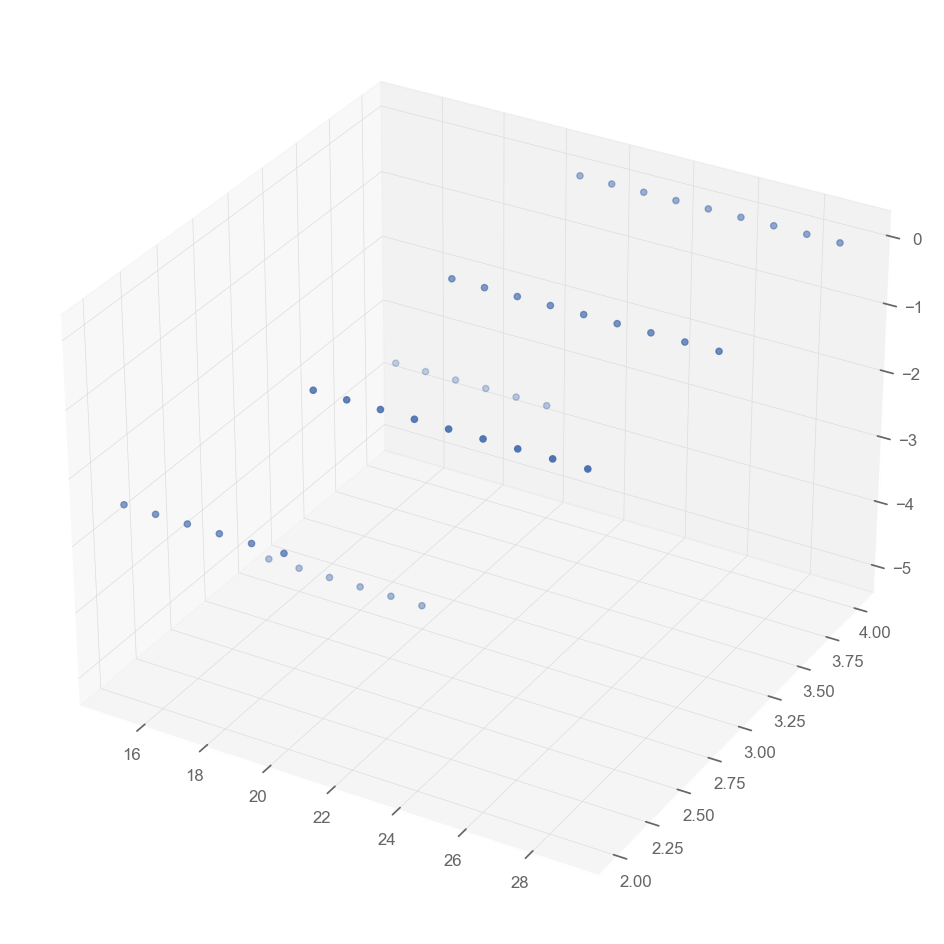

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter([i[0] for i in param_list], [i[1] for i in param_list], [i[2] for i in param_list])
plt.show()